# Distance Metrics

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
import numpy as np
np.random.seed(1) # Set seed for reproducibility

from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim.matutils import hellinger, jaccard, kullback_leibler

import itertools
import networkx as nx

2020-06-18 03:42:00,397 : INFO : 'pattern' package not found; tag filters are not available for English


In [ ]:
# toy corpus for illustrative purposes
texts = [['bank','river','shore','water'],
        ['river','water','flow','fast','tree'],
        ['bank','water','fall','flow'],
        ['bank','bank','water','rain','river'],
        ['river','water','mud','tree'],
        ['money','transaction','bank','finance'],
        ['bank','borrow','money'],
        ['bank','finance'],
        ['finance','money','sell','bank'],
        ['borrow','sell'],
        ['bank','loan','sell']]

dictionary = Dictionary(texts)
corpus = [ dictionary.doc2bow(text) for text in texts ]

2020-06-18 03:42:00,567 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-18 03:42:00,569 : INFO : built Dictionary(16 unique tokens: ['bank', 'river', 'shore', 'water', 'fast']...) from 11 documents (total 40 corpus positions)


In [ ]:
# Train LDA model
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=2, minimum_probability=1e-8)

2020-06-18 03:42:00,576 : INFO : using symmetric alpha at 0.5
2020-06-18 03:42:00,578 : INFO : using symmetric eta at 0.5
2020-06-18 03:42:00,579 : INFO : using serial LDA version on this node
2020-06-18 03:42:00,580 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 11 documents, updating model once every 11 documents, evaluating perplexity every 11 documents, iterating 50x with a convergence threshold of 0.001000
2020-06-18 03:42:00,580 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-06-18 03:42:00,601 : INFO : -3.572 per-word bound, 11.9 perplexity estimate based on a held-out corpus of 11 documents with 40 words
2020-06-18 03:42:00,602 : INFO : PROGRESS: pass 0, at document #11/11
2020-06-18 03:42:00,619 : INFO : topic #0 (0.500): 0.207*"bank" + 0.100*"water" + 0.089*"river" + 0.088*"sell" + 0.067*"borrow" + 0.064*"finance" + 0.062*"money" + 0.05

In [ ]:
# Topics learned by the model
model.show_topics()

[(0,
  '0.207*"bank" + 0.100*"water" + 0.089*"river" + 0.088*"sell" + 0.067*"borrow" + 0.064*"finance" + 0.062*"money" + 0.053*"tree" + 0.045*"flow" + 0.044*"rain"'),
 (1,
  '0.142*"bank" + 0.116*"water" + 0.090*"river" + 0.084*"money" + 0.081*"finance" + 0.064*"flow" + 0.055*"transaction" + 0.055*"tree" + 0.053*"fall" + 0.050*"mud"')]

In [ ]:
# Test documents
doc_water = ['river', 'water', 'shore']
doc_finance = ['finance', 'money', 'sell']
doc_bank = ['finance', 'bank', 'tree', 'water']

# Convert test docs into BoW format
bow_water = model.id2word.doc2bow(doc_water)
bow_finance = model.id2word.doc2bow(doc_finance)
bow_bank = model.id2word.doc2bow(doc_bank)

# Get LDA topic distributions for test documents
lda_water = model[bow_water]
lda_finance = model[bow_finance]
lda_bank = model[bow_bank]

# Print topic distributions
print(lda_water)
print(lda_finance)
print(lda_bank)

[(0, 0.30758294), (1, 0.6924171)]
[(0, 0.6501373), (1, 0.3498627)]
[(0, 0.64021087), (1, 0.35978913)]


**Hellinger Distance**

> The Hellinger distance metric gives an output in the range [0,1] for two probability distributions, with values closer to 0 meaning they are more similar.



In [ ]:
print(hellinger(lda_water, lda_finance))
print(hellinger(lda_finance, lda_bank))

0.24622909657015662
0.007335167626145516


**Kullback–Leibler Divergence**

In [ ]:
print(kullback_leibler(lda_water, lda_finance))
print(kullback_leibler(lda_finance, lda_bank))
print(kullback_leibler(lda_bank, lda_finance))

0.24246992
0.0002147695
0.00021567382


**Jaccard distance**

> Jaccard distance is defined as 1 minus the size of the intersection divided the size of the union of the vectors. A distance of 0 indicates that the vectors are identical and a distance of 1 indicates that the vectors have no two components that are same.



In [ ]:
print(jaccard(bow_water, bow_finance))
print(jaccard(bow_finance,bow_bank))

1.0
0.8571428571428572


## **Distance Metrics for Topic Distributions**

In [ ]:
# Get topic distributions
topic_water, topic_finance = model.show_topics()

In [ ]:
# Preprocess to get topic BoW
def parse_topic_string(topic):
  # takes the string returned by model.show_topics()
  # split on strings to get topics and the probabilities
  topic = topic.split('+')
  
  # list to store topic BoWs
  topic_bow = []

  for word in topic:
    # split probability and word
    prob, word = word.split('*')

    # remove space and quote marks
    word = word.replace(" ", "").replace('"', '')

    # extract word id
    word = model.id2word.doc2bow([word])[0][0]

    topic_bow.append((word, float(prob)))
  
  return topic_bow

finance_dist = parse_topic_string(topic_finance[1])
water_dist = parse_topic_string(topic_water[1])

In [ ]:
# BoW representation of the topic finance
print(finance_dist)

[(0, 0.142), (3, 0.116), (1, 0.09), (11, 0.084), (10, 0.081), (5, 0.064), (12, 0.055), (6, 0.055), (7, 0.053), (9, 0.05)]


In [ ]:
# BoW representation of the topic water
print(water_dist)

[(0, 0.207), (3, 0.1), (1, 0.089), (14, 0.088), (13, 0.067), (10, 0.064), (11, 0.062), (6, 0.053), (5, 0.045), (8, 0.044)]


In [ ]:
print(hellinger(water_dist, finance_dist))

0.42898539619904935


In [ ]:
model.show_topics(num_words=len(model.id2word))

[(0,
  '0.207*"bank" + 0.100*"water" + 0.089*"river" + 0.088*"sell" + 0.067*"borrow" + 0.064*"finance" + 0.062*"money" + 0.053*"tree" + 0.045*"flow" + 0.044*"rain" + 0.042*"fast" + 0.038*"loan" + 0.033*"shore" + 0.025*"mud" + 0.022*"fall" + 0.021*"transaction"'),
 (1,
  '0.142*"bank" + 0.116*"water" + 0.090*"river" + 0.084*"money" + 0.081*"finance" + 0.064*"flow" + 0.055*"transaction" + 0.055*"tree" + 0.053*"fall" + 0.050*"mud" + 0.050*"sell" + 0.039*"shore" + 0.036*"borrow" + 0.033*"loan" + 0.028*"fast" + 0.025*"rain"')]

## **Visualizing Distance Metrics**

> Each node will be a document, where the color of the node will be its topic according to the LDA model. Edges will connect documents to each other, where the weight of the edge will be inversely proportional to the Jaccard similarity between two documents. We will also annotate the edges to further aid visualization: strong edges will connect similar documents, and weak (dashed) edges will connect dissimilar documents. In summary, similar documents will be closer together, different documents will be further apart.

{0: Text(0.5623713119654535, -0.5654949275102867, '0'),
 1: Text(-0.4663601964529483, -0.6704630663732092, '1'),
 2: Text(-0.30624897543315965, 0.9162694996045158, '2'),
 3: Text(0.4247862302728536, 0.7444862691011674, '3'),
 4: Text(0.9351312878962134, -0.20600448573794963, '4'),
 5: Text(0.7876621584477874, 0.3688167238515861, '5'),
 6: Text(0.048188122211134096, -0.9116393631071852, '6'),
 7: Text(-0.14300919055140138, 0.405662886157678, '7'),
 8: Text(0.00650692154979198, -0.1353255005580942, '8'),
 9: Text(-0.9999999999999999, -0.3170708342089091, '9'),
 10: Text(-0.8490276699057261, 0.3707627987806906, '10')}

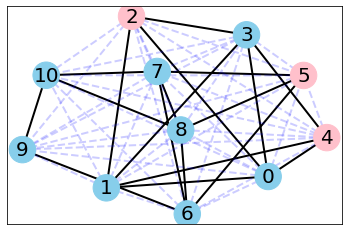

In [ ]:
# Get topic corresponding to maximum probability
def get_most_likely_topic(doc):
  bow = model.id2word.doc2bow(doc)
  topics, prob = zip(*model.get_document_topics(bow))
  max_p = max(prob)
  topic = topics[prob.index(max_p)]
  return topic

def get_node_color(i):
    return 'skyblue' if get_most_likely_topic(texts[i]) == 0 else 'pink'

G = nx.Graph()
for i, _ in enumerate(texts):
    G.add_node(i)

for (i1, i2) in itertools.combinations(range(len(texts)), 2):
    bow1, bow2 = texts[i1], texts[i2]
    distance = jaccard(bow1, bow2)
    G.add_edge(i1, i2, weight=1/distance)

#
# https://networkx.github.io/documentation/networkx-1.9/examples/drawing/weighted_graph.html
#
pos = nx.spring_layout(G)

threshold = 1.25
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > threshold]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= threshold]

node_colors = [get_node_color(i) for (i, _) in enumerate(texts)]
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
nx.draw_networkx_edges(G,pos,edgelist=elarge, width=2)
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=2, alpha=0.2, edge_color='b', style='dashed')
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

In [ ]:
print('id\ttopic\tdoc')
for i, t in enumerate(texts):
    print('%d\t%d\t%s' % (i, get_most_likely_topic(t), ' '.join(t)))

id	topic	doc
0	0	bank river shore water
1	0	river water flow fast tree
2	1	bank water fall flow
3	0	bank bank water rain river
4	1	river water mud tree
5	1	money transaction bank finance
6	0	bank borrow money
7	0	bank finance
8	0	finance money sell bank
9	0	borrow sell
10	0	bank loan sell
